In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.api as smt
import statsmodels.tsa.stattools as st
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from itertools import product  
from tqdm import tqdm_notebook

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y/%m/%d %H:%M:%S.%f.')
data = pd.read_csv('car.csv',encoding = 'gb18030',parse_dates=['时间'],index_col='时间',date_parser=dateparse)
data.sort_index(inplace=True)

In [3]:
data.head()

,经度,纬度,海拔,GPS车速,GPS里程,GPS方向,远程控制结束标志位,制冷模式指令,除霜模式指令,制热模式指令,...,高低压互锁电压,出租车报警电压,ECC零部件号后四位,ECC软件版本号后两位,PTC零部件号后四位,PTC软件版本号后两位,EPS零部件号后四位,EPS软件版本号后两位,CHG零部件号后四位,CHG软件版本号后两位
时间,,,,,,,,,,,,,,,,,,,,,
2016-04-12 07:09:20,0.0,0.0,0,0.0,2146.2,0,0,0,0,0,...,0,0.45,33837,84,0,18,1,51,0,0
2016-04-12 07:09:20,0.0,0.0,0,0.0,2146.2,0,0,0,0,0,...,0,0.45,33837,84,0,18,1,51,0,0
2016-04-12 07:09:30,0.0,0.0,0,0.0,2146.2,0,1,0,0,0,...,0,0.45,33837,84,0,18,1,51,0,0
2016-04-12 07:09:30,0.0,0.0,0,0.0,2146.2,0,1,0,0,0,...,0,0.45,33837,84,0,18,1,51,0,0
2016-04-12 07:09:40,0.0,0.0,0,0.0,2146.2,0,1,0,0,0,...,0,0.45,33837,84,0,18,1,51,0,0


# For what period is this set of data captured?

由图可知，数据检测的点主要分布在早上7点到晚上23点之间，其中4月17日，4月22日，4月24日，5月24日，6月17日，6月18日没有检测的数据。由图可知，每天检测的时间点不一定是连续的

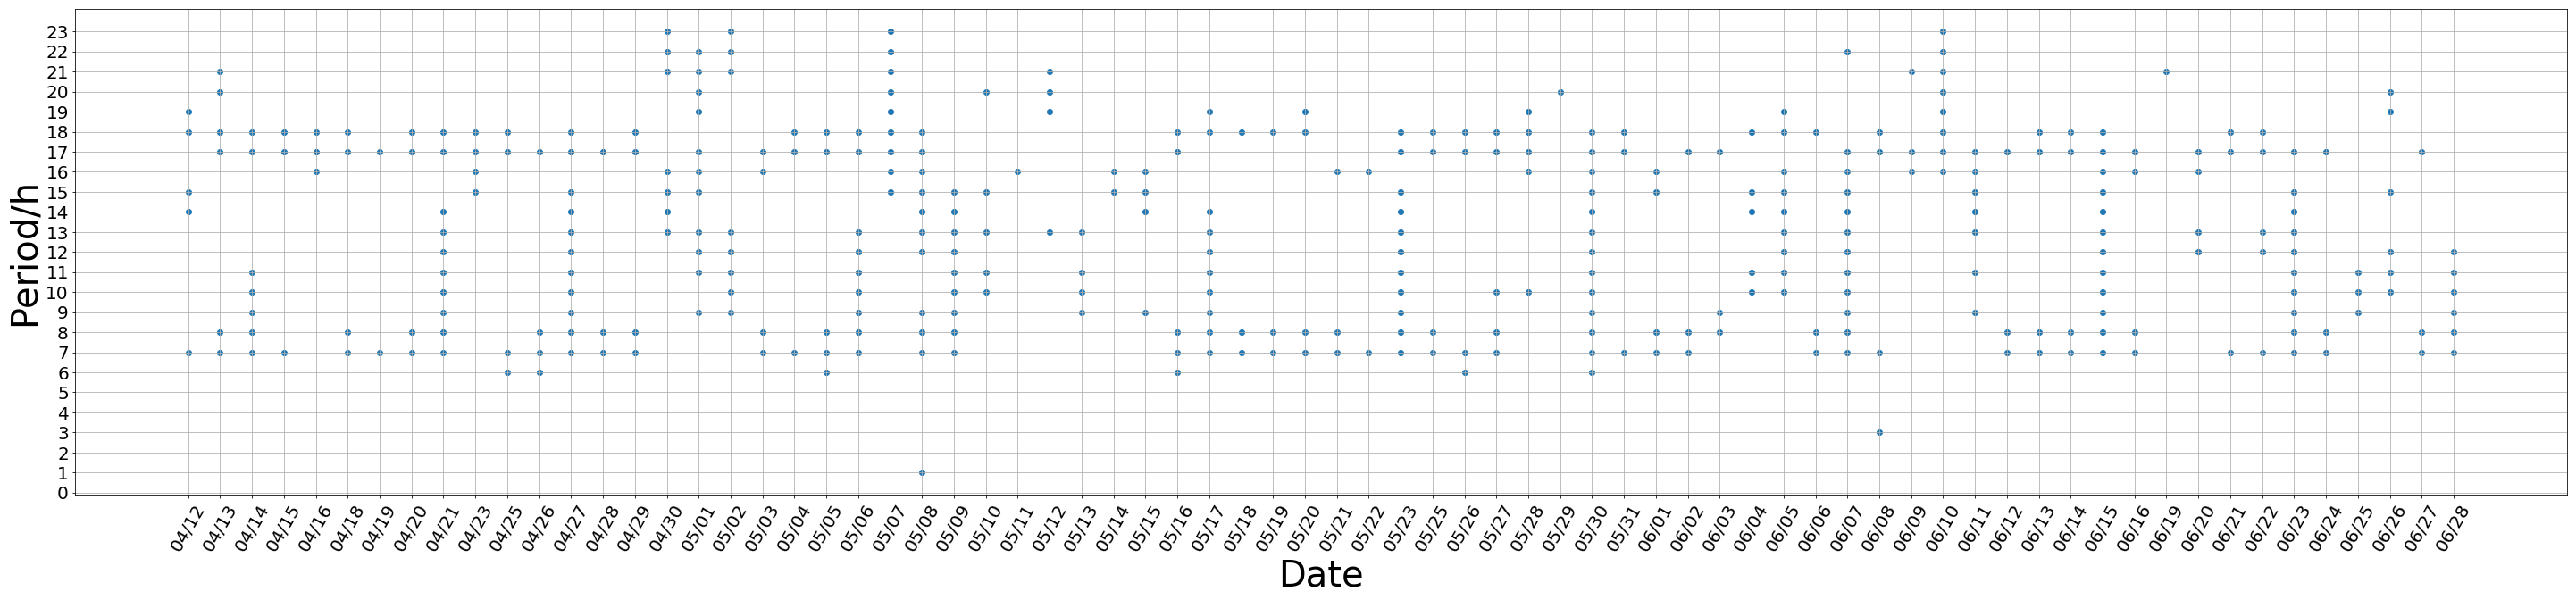

In [4]:

list_ = data.index.strftime('%Y/%m/%d %H')
date_rng = pd.date_range(start='2016-04-12', end='2016-06-28')
dict_hour = {}
list_date_ = []
list_hour_ = []
for da in date_rng:
    date_hour = pd.date_range(start=da, periods=24, freq = 'H')
    for hour in date_hour:
        tim = str(hour.strftime('%Y/%m/%d %H'))
        if tim in list_:
            dict_hour.setdefault(str(hour.strftime('%m/%d')),[]).append(int(hour.strftime('%H')))
            list_date_.append(str(hour.strftime('%m/%d')))
            list_hour_.append(int(hour.strftime('%H')))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.figure(figsize=(50,10))
plt.scatter(list_date_,list_hour_)
plt.xticks(rotation = 60)
plt.yticks([i for i in range(0,24)])
plt.xlabel('Date', fontsize = 40)
plt.ylabel('Period/h', fontsize = 40)

plt.grid()
plt.show()

# How many of the features appear to be constant machine settings?

计算每一列的variance来筛选zero-variance的特征，如果某一特征的variance为0，就认为该特征是一个恒定的值，经统计，一共有31个特征是恒定常数。

In [22]:
for i in data.loc[:,data.var()==0.0].columns:
    print(i)
print('There are %d features appear to be constant machine settings' %(len(data.loc[:,data.var()==0.0].columns)))

制冷模式指令
除霜模式指令
制热模式指令
交流充电模式指令
动力电池加热模式指令
远程开关状态
远程唤醒信号
高压系统检测状态超时
VCU故障处理等级
驻车指令
高压上电指令
电子驻车制动系统当前状态
电子驻车制动系统初始化状态
动力电池可用能量
动力电池当前状态
动力加热状态
动力电池保温状态
紧急开关状态
冷却风扇当前状态
EPS助力电机当前转矩
电池92#单体电压
电池93#单体电压
电池94#单体电压
电池95#单体电压
电池96#单体电压
电池97#单体电压
电池98#单体电压
电池99#单体电压
电池100#单体电压
高低压互锁电压
PTC零部件号后四位
There are 31 features appear to be constant machine settings


# Plot the daily mean for 温度检测点1号温度 and 温度检测点2号温度.

由图可见检测点1号温度和检测点2号温度的趋势是基本相同的。有部分天数的数据缺失了，分别是4月17日，4月22日，4月24日，5月24日，6月17日，6月18日
用前一天和后一天数据的均值对缺失的数据进行填补

In [29]:
data_1 = data['温度检测点1号温度']
data_2 = data['温度检测点2号温度']
df1 = data_1.resample('D').mean()
df2 = data_2.resample('D').mean()

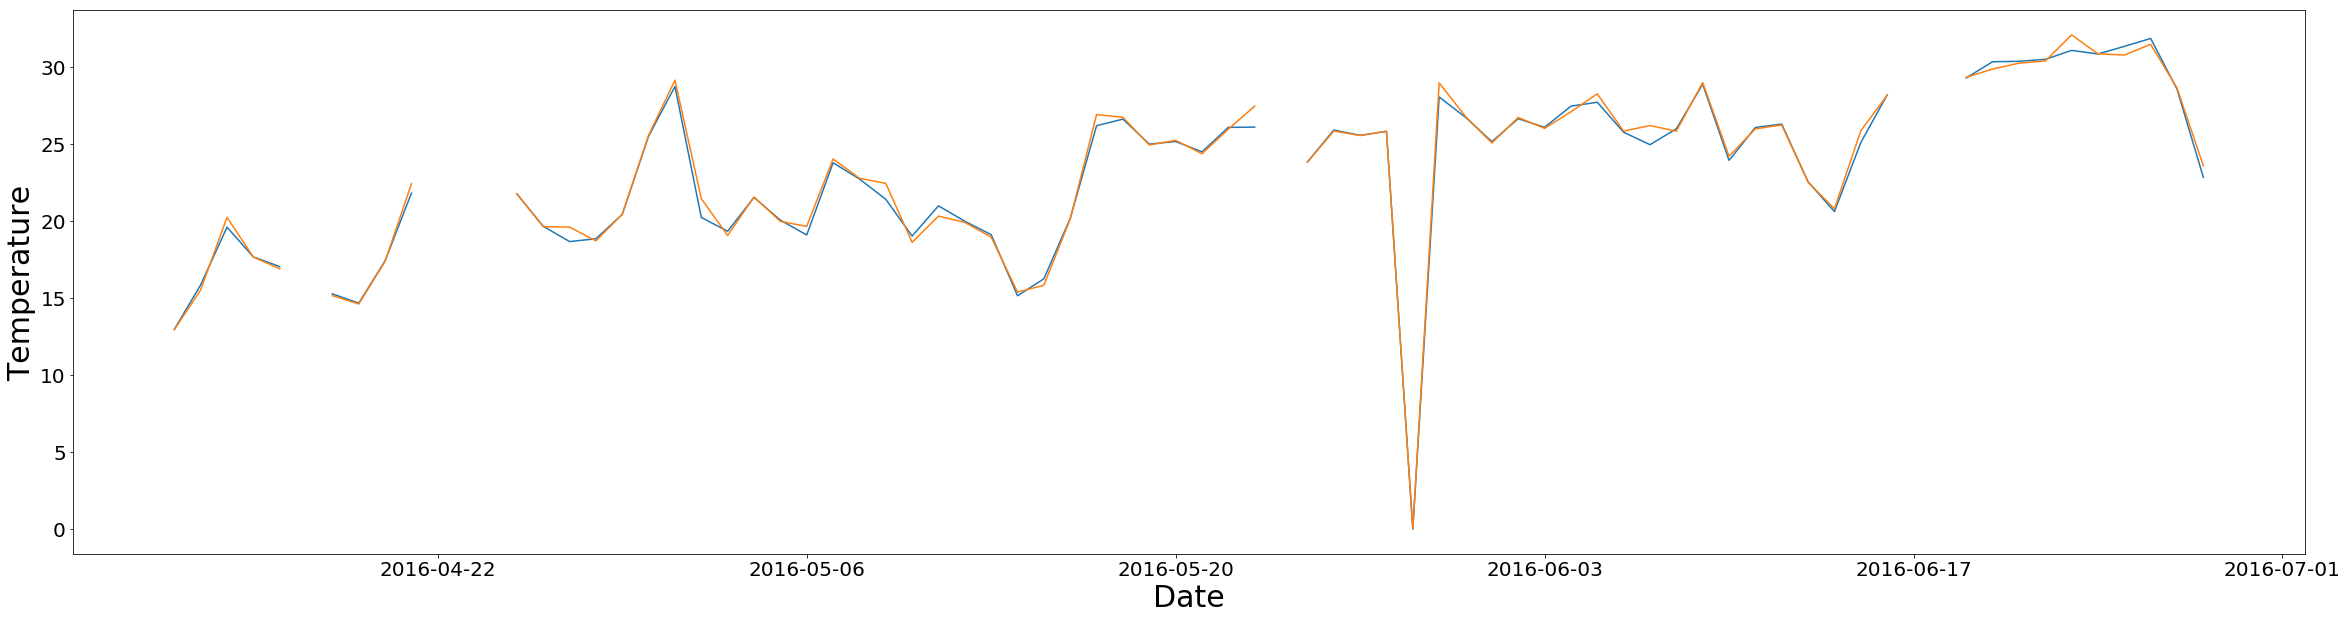

In [30]:
plt.figure(figsize=(40,10))
plt.plot(df1, label='T1')
plt.plot(df2, label='T2')
plt.xlabel('Date', fontsize=30)
plt.ylabel('Temperature',fontsize=30)
plt.show()

In [33]:
#检测数据缺失的日期
df1[df1.isnull().where(lambda x : x == True) ==1.0]

时间
2016-04-17   NaN
2016-04-22   NaN
2016-04-24   NaN
2016-05-24   NaN
2016-06-17   NaN
2016-06-18   NaN
Name: 温度检测点1号温度, dtype: float64

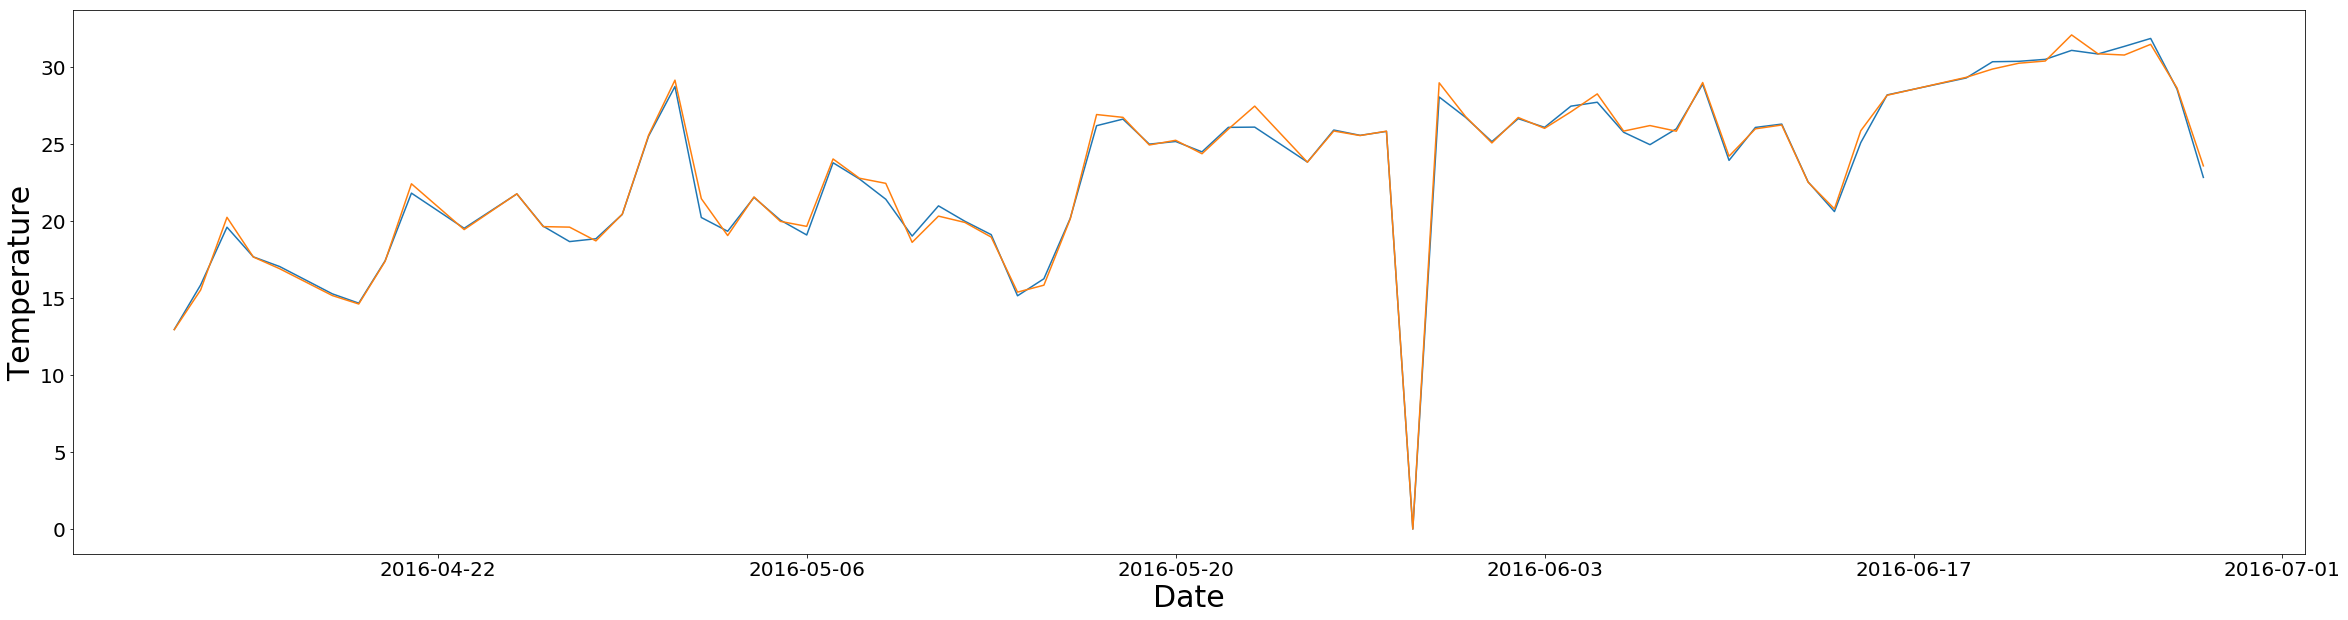

In [42]:
#填补缺失的数据
df_fill = pd.DataFrame(df1.interpolate())
df2_fill = pd.DataFrame(df2.interpolate())
plt.figure(figsize=(40,10))
plt.plot(df_fill, label='T1')
plt.plot(df2_fill, label='T2')
plt.xlabel('Date', fontsize=30)
plt.ylabel('Temperature',fontsize=30)
plt.show()

In [61]:
df_fill[df_fill.index == '2016-05-29 00:00:00']

,温度检测点1号温度
时间,
2016-05-29,0.0


# What period appears to have an abnormal value compared to a baseline?


计算置信区间
<br>
lower_bond = rolling_mean - (mae + scale * deviation)
<br>
upper_bond = rolling_mean + (mae + scale * deviation)
<br>
其中
<br>
rolling_mean = series.rolling(window).mean()
<br>
mae = mean_absolute_error(series[window:], rolling_mean[window:])
<br>
deviation = np.std(series[window:] - rolling_mean[window:])
<br>
如果时间序列里的某个值超出了置信区间。则标注这个值为异常值，可以看到5月29日的数值是异常值

In [50]:
#异常值检测
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
            
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()

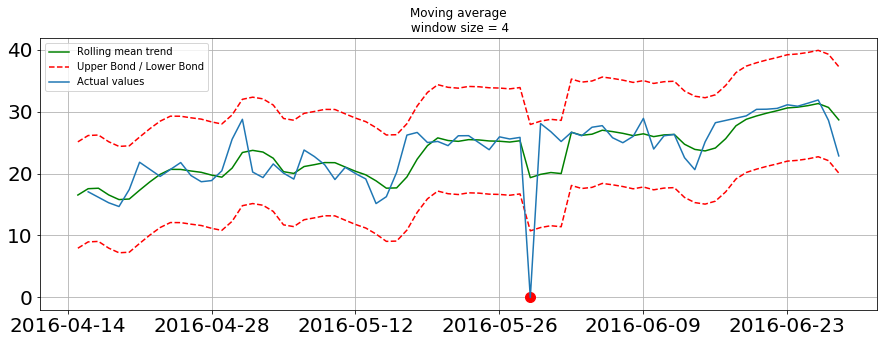

In [51]:
plotMovingAverage(df_fill, 4, plot_intervals=True, plot_anomalies=True)

将异常值剔除

In [74]:
#为不影响预测，将异常值剔除
df_fill[df_fill.index == '2016-05-29 00:00:00'] = np.nan
df_fill = df_fill.interpolate()

# Is the data stationary? If not, what does it imply and what would you do?

用三种种方法检测数据的平稳性,以温度检测点1号温度为例
<br>
> 移动平均法
<br>
> Dickey-Fuller测试
<br>
> ACF和PACF图像
<br>

温度检测点1号温度的移动平均有一个逐渐升高的趋势

/Users/chenlianxu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.
/Users/chenlianxu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).std()
  """


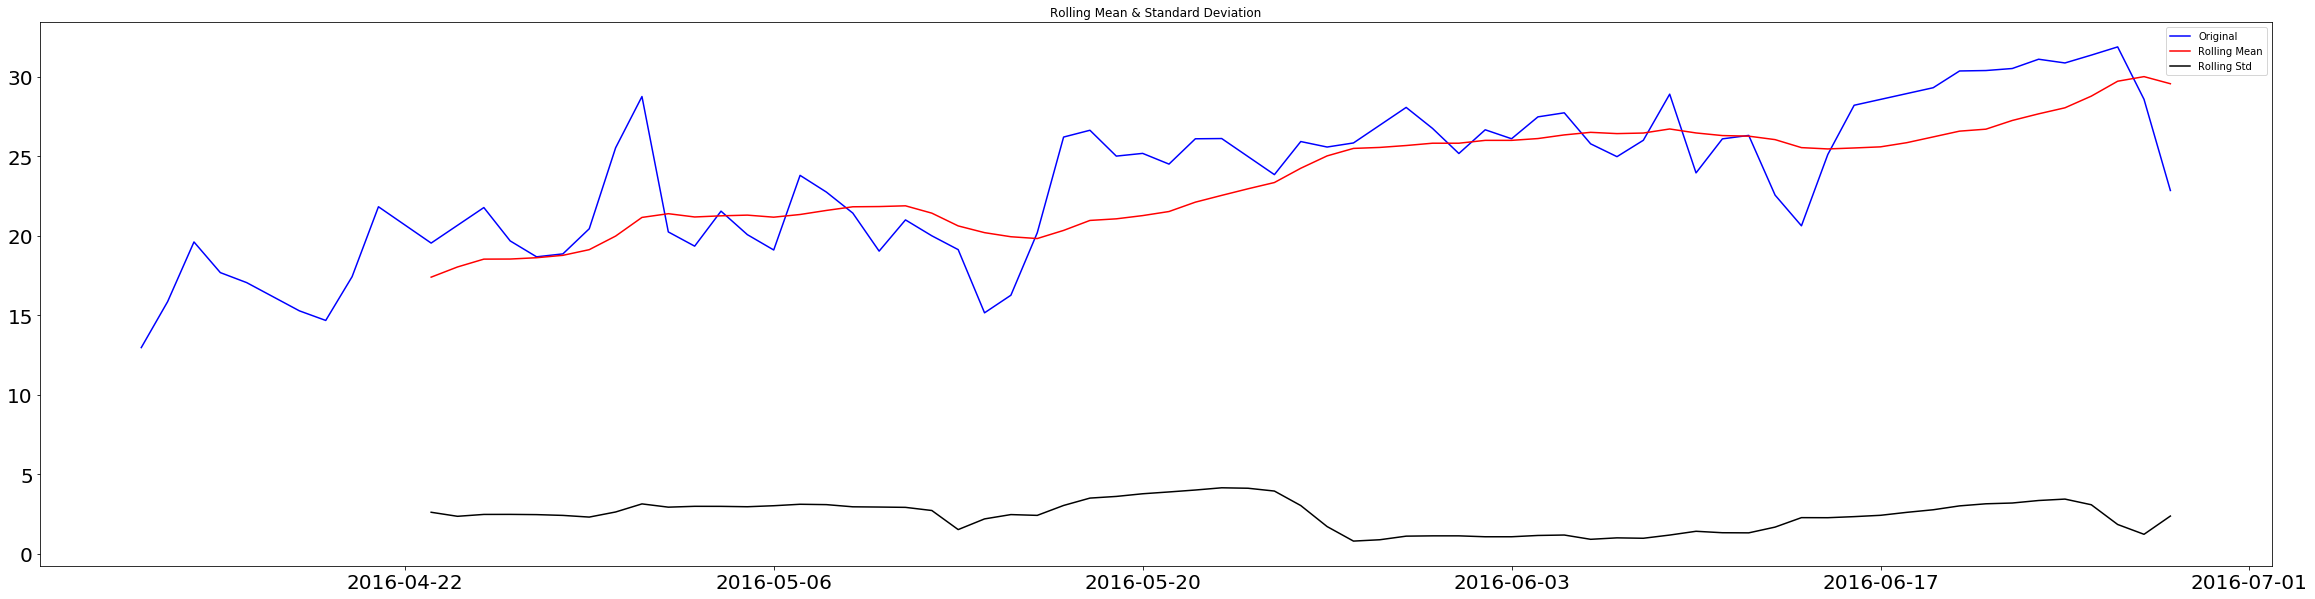

In [76]:
#移动平均法
def rolling_statistics(timeseries):
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)
 
    #Plot rolling statistics:
    plt.figure(figsize=(40,10))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

rolling_statistics(df_fill)

Dickey-Fuller测试 
<br>
测试的test Statistic 值大于critical value

In [77]:
dftest = adfuller(df_fill.温度检测点1号温度, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                 -2.026320
p-value                         0.275153
#Lags Used                      2.000000
Number of Observations Used    75.000000
Critical Value (1%)            -3.520713
Critical Value (5%)            -2.900925
Critical Value (10%)           -2.587781
dtype: float64


ACF和PACF图
<br>
可以看到数据的acf图和pacf图都不是截尾或者拖尾的，综上三种方法，我们可以确定该时间序列不是平稳的

In [80]:
#Dickey-Fuller测试和acf,pacf图
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        plt.show()

/Users/chenlianxu/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


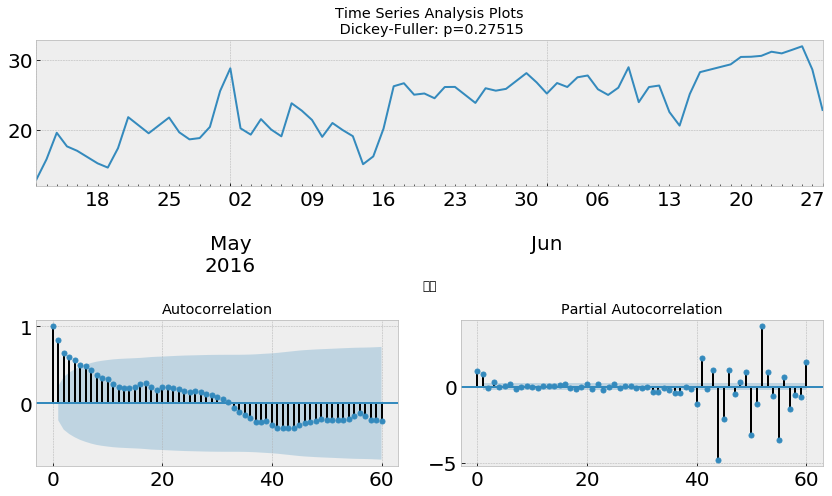

In [81]:
tsplot(df_fill.温度检测点1号温度, lags=60)

# 将时间序列变平整

可以看到经过log变换和差分处理的时间序列变得平整了

/Users/chenlianxu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.
/Users/chenlianxu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=12,center=False).std()
  """


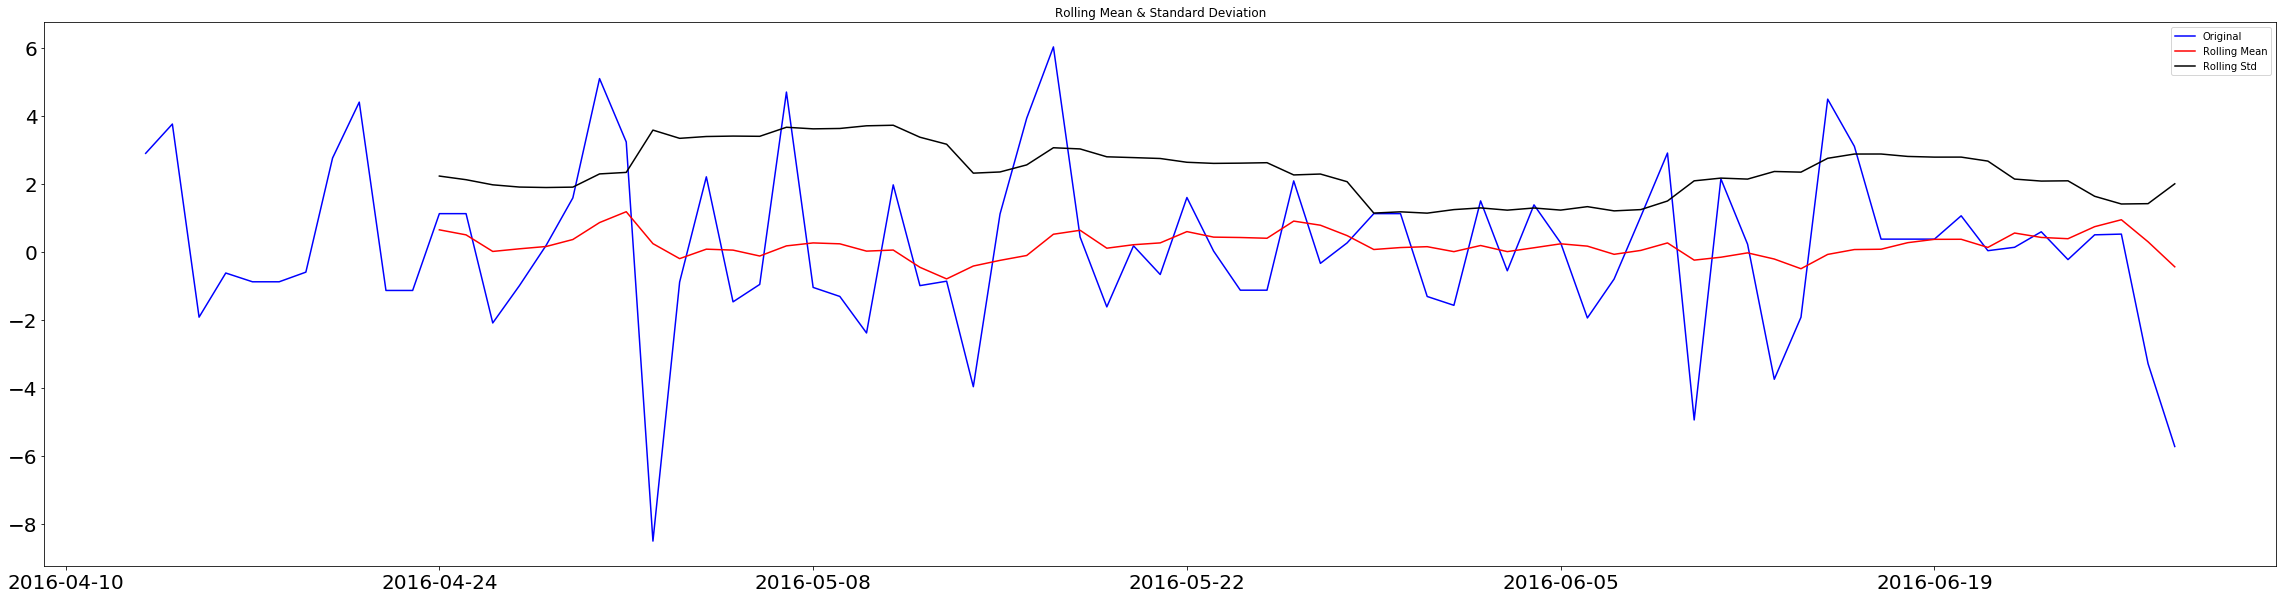

In [137]:
#为了消除时间序列的趋势，做差分处理
df_fill_diff = df_fill - df_fill.shift()
rolling_statistics(df_fill_diff)

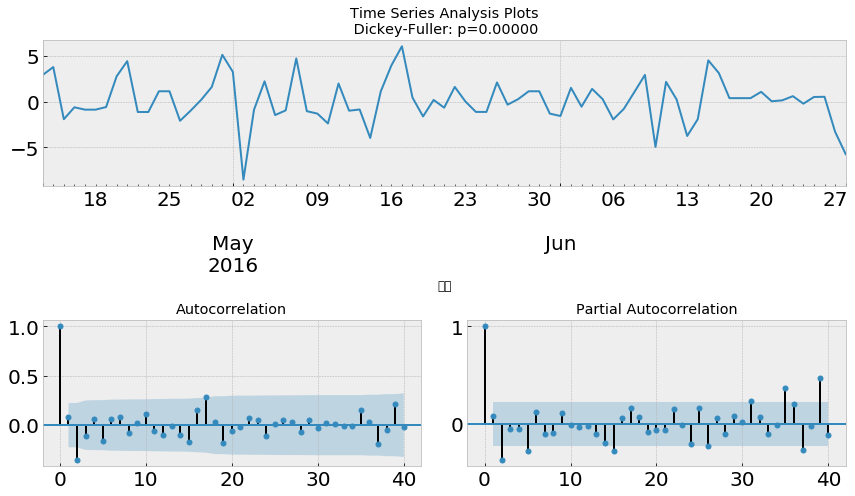

In [138]:
df_fill_diff.dropna(inplace=True)
tsplot(df_fill_diff.温度检测点1号温度, lags=40)

# 选择ARIMA模型

p – The lag value where the PACF chart crosses the upper confidence interval for the first time. 
<br>
q – The lag value where the ACF chart crosses the upper confidence interval for the first time.

In [139]:
# 选择模型最佳参数
ps = range(2, 6)
d=1
qs = range(2, 6)

# creating list with all the possible combinations of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)


def optimizeARIMA(parameters_list, d):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model = ARIMA(df_fill,(param[0],d,param[1])).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [140]:
result_table = optimizeARIMA(parameters_list, d)
result_table

A Jupyter Widget

/Users/chenlianxu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/chenlianxu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:676: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Users/chenlianxu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:650: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/chenlianxu/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/chenlianxu/anaconda3/lib/python3.6/site-packages/statsmodels/tools/numdiff.py:243: RuntimeWarning: invalid value encountered in add
  **kwargs)).imag/2./hess[i, j]
/Users/chenli

/Users/chenlianxu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


,parameters,aic
0,"(3, 5)",342.783771
1,"(2, 2)",345.078167
2,"(3, 2)",346.583492
3,"(5, 2)",347.352514
4,"(4, 5)",347.772936
5,"(4, 4)",348.019059
6,"(4, 2)",348.207987
7,"(5, 3)",348.601252
8,"(5, 5)",349.015978
9,"(5, 4)",350.285206


In [144]:
best_model = ARIMA(df_fill.温度检测点1号温度, order=(3, 1, 5)).fit(disp=-1)
print(best_model.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.温度检测点1号温度   No. Observations:                   77
Model:                 ARIMA(3, 1, 5)   Log Likelihood                -161.392
Method:                       css-mle   S.D. of innovations              1.873
Date:                Sat, 10 Nov 2018   AIC                            342.784
Time:                        22:08:13   BIC                            366.222
Sample:                    04-13-2016   HQIC                           352.159
                         - 06-28-2016                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1620      0.022      7.404      0.000       0.119       0.205
ar.L1.D.温度检测点1号温度    -0.6169      0.203     -3.042      0.003      -1.014      -0.219
ar.L2.D.温度检测点1号温度    -1.

/Users/chenlianxu/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


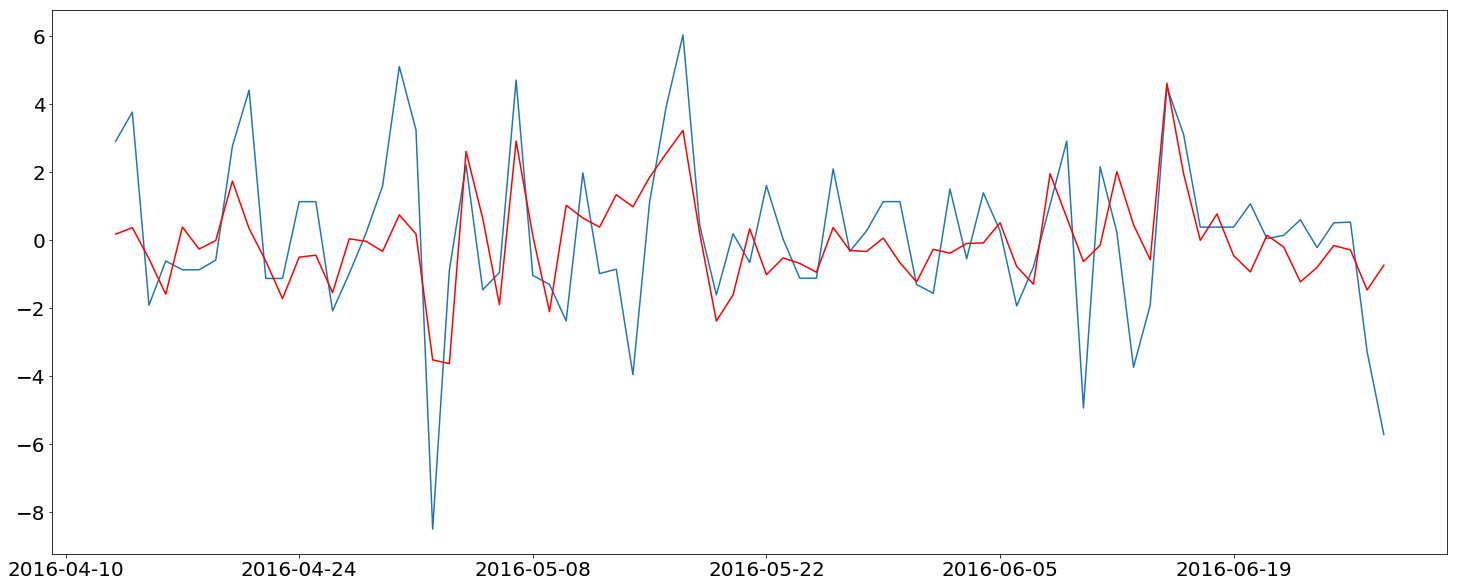

In [145]:
plt.figure(figsize=(25,10))
plt.plot(df_fill_diff)
plt.plot(best_model.fittedvalues, color='red')
plt.show()

In [146]:
best_model.forecast(5)

(array([25.01393765, 28.15822844, 29.40289591, 30.6520495 , 28.50157879]),
 array([1.87329037, 2.5816999 , 2.7135069 , 2.71398452, 2.71404217]),
 array([[21.342356  , 28.68551929],
        [23.09818961, 33.21826726],
        [24.08452012, 34.7212717 ],
        [25.33273758, 35.97136142],
        [23.18215389, 33.82100369]]))

模型的置信区间可以为 
置信区间 = [模型预测值-1.96*模型标准差 , 模型预测值+1.96*模型标准差]

In [147]:
predict_arima_diff = pd.Series(best_model.fittedvalues, copy=True)

In [148]:
predict_arima_diff_cumsum = predict_arima_diff.cumsum()

In [149]:
predict_arima = pd.Series(df_fill.iloc[0].values,index=df_fill.index)

In [150]:
predict_arima = predict_arima.add(predict_arima_diff_cumsum,fill_value=0)

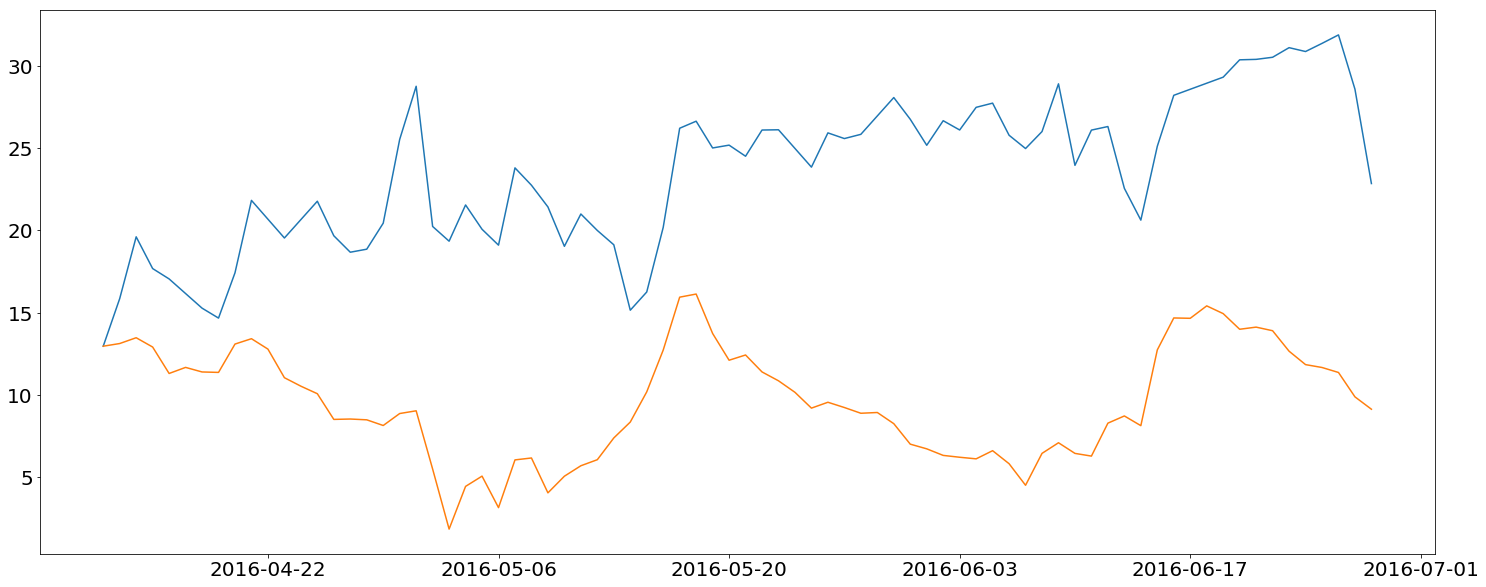

In [151]:
plt.figure(figsize=(25,10))
plt.plot(df_fill)
plt.plot(predict_arima)
plt.show()

# 线性回归

In [153]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit 
# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [154]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [171]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)


In [174]:
lr = LinearRegression()
lr.fit(X_train, y_train)

/Users/chenlianxu/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [177]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed')
    plt.show()

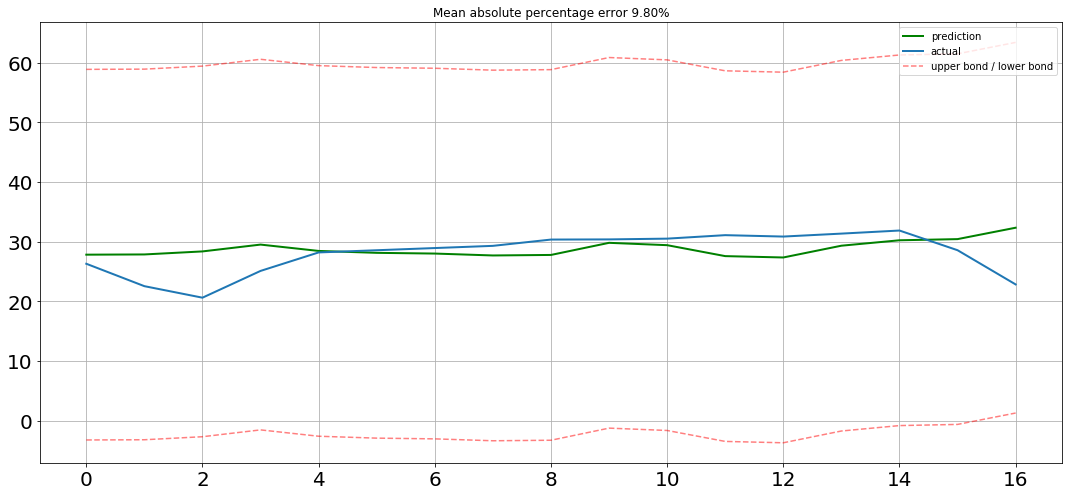

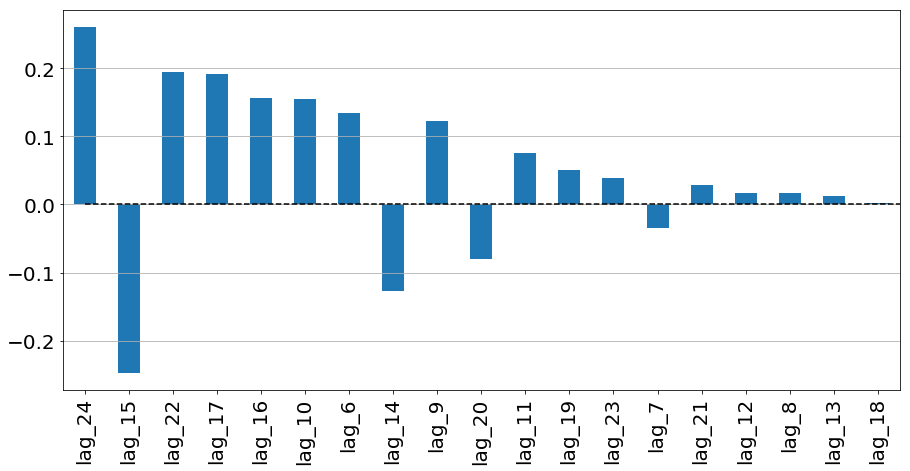

In [179]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)